#Master Project 2

##Importing Libraries and Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prettytable import PrettyTable
from xgboost import plot_importance, plot_tree
from sklearn.metrics import r2_score

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

df = pd.read_csv('/content/gdrive/My Drive/UTM/Master Project 2/newdata.csv',encoding='latin-1')

Mounted at /content/gdrive


##User-defined Functions

In [ ]:
def remove_outliers(df,var):
  LB = df[var].quantile(0.05)
  UB = df[var].quantile(0.95)
  print(f"LB = {LB:0.2f}, UB = {UB:0.2f}")

  tempdf=df.copy()
  tempdf.loc[tempdf[var]<LB,var]=LB
  tempdf.loc[tempdf[var]>UB,var]=UB

  return tempdf

In [ ]:
def split_data(df,trainsize):
  train_num=int(trainsize*df.shape[0])
  train=df.loc[:train_num-1,:]
  test=df.loc[train_num:,:]
  print("train_num="+str(train.shape[0])+", test_num="+str(test.shape[0]))
  xtrain=train[['Year','Month']]
  ytrain=train['Scaled Demand']
  xtest=test[['Year','Month']]
  ytest=test['Scaled Demand']
  return test,train,xtrain,xtest,ytrain,ytest

In [ ]:
def evaluation(xtrain,xtest,ytrain,ytest):
  # Make predictions using the training and testing set
  y_train_pred = reg.predict(xtrain)
  y_test_pred = reg.predict(xtest)

  print('MSE   train: %.2f, test: %.2f' %
        (mean_squared_error(ytrain, y_train_pred),
        mean_squared_error(ytest, y_test_pred)))

  print('RMSE  train: %.2f, test: %.2f' %
        (np.sqrt(mean_squared_error(ytrain, y_train_pred)),
        np.sqrt(mean_squared_error(ytest, y_test_pred))))

  print('MAE   train: %.2f, test: %.2f' %
        (mean_absolute_error(ytrain, y_train_pred),
        mean_absolute_error(ytest, y_test_pred)))

##Data Pre-processing

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            10324 non-null  int64  
 1   Project Code                  10324 non-null  object 
 2   PQ #                          10324 non-null  object 
 3   PO / SO #                     10324 non-null  object 
 4   ASN/DN #                      10324 non-null  object 
 5   Country                       10324 non-null  object 
 6   Managed By                    10324 non-null  object 
 7   Fulfill Via                   10324 non-null  object 
 8   Vendor INCO Term              10324 non-null  object 
 9   Shipment Mode                 9964 non-null   object 
 10  PQ First Sent to Client Date  10324 non-null  object 
 11  PO Sent to Vendor Date        10324 non-null  object 
 12  Scheduled Delivery Date       10324 non-null  object 
 13  D

In [ ]:
df.head()

,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,...,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,...,30,19,551.0,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.34,NaN
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,...,240,1000,6200.0,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.5,NaN
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,...,100,500,40000.0,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.78,NaN
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,...,60,31920,127360.8,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.06,NaN
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,...,60,38000,121600.0,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.08,NaN


In [ ]:
df2=df['Scheduled Delivery Date']
df2=df2.to_frame()
df2['Demand']=df['Line Item Quantity']
df2.head()

,Scheduled Delivery Date,Demand
0,2-Jun-06,19
1,14-Nov-06,1000
2,27-Aug-06,500
3,1-Sep-06,31920
4,11-Aug-06,38000


In [ ]:
df2.isna().sum()

Scheduled Delivery Date    0
Demand                     0
dtype: int64

In [ ]:
df2['Scheduled Delivery Date']=pd.to_datetime(df2['Scheduled Delivery Date'])

In [ ]:
df2['Year']=df2['Scheduled Delivery Date'].dt.year
df2['Month']=df2['Scheduled Delivery Date'].dt.month
df2['Day']=df2['Scheduled Delivery Date'].dt.day
df2

,Scheduled Delivery Date,Demand,Year,Month,Day
0,2006-06-02,19,2006,6,2
1,2006-11-14,1000,2006,11,14
2,2006-08-27,500,2006,8,27
3,2006-09-01,31920,2006,9,1
4,2006-08-11,38000,2006,8,11
...,...,...,...,...,...
10319,2015-07-31,166571,2015,7,31
10320,2015-07-31,21072,2015,7,31
10321,2015-08-31,514526,2015,8,31
10322,2015-09-09,17465,2015,9,9


In [ ]:
df3=df2.groupby(by=['Year','Month']).sum()
df3.reset_index(inplace=True)
df3.drop(columns='Day',inplace=True)
df3

,Year,Month,Demand
0,2006,5,75
1,2006,6,166
2,2006,7,506
3,2006,8,94019
4,2006,9,135948
...,...,...,...
110,2015,7,1527456
111,2015,8,1848748
112,2015,9,230869
113,2015,10,134500


In [ ]:
multi_index = pd.MultiIndex.from_product([df3['Year'].unique(), range(1,13)], names=['Year', 'Month'])
temp = df3.set_index(['Year','Month']).reindex(multi_index).reset_index()

In [ ]:
temp=temp[temp['Year']!=2006]
temp=temp[temp['Year']!=2015]
temp

,Year,Month,Demand
12,2007,1,56546.0
13,2007,2,119143.0
14,2007,3,406619.0
15,2007,4,260737.0
16,2007,5,410642.0
...,...,...,...
103,2014,8,2637618.0
104,2014,9,3198768.0
105,2014,10,1895477.0
106,2014,11,1749887.0


In [ ]:
temp.isna().sum()

Year      0
Month     0
Demand    0
dtype: int64

In [ ]:
temp['Demand']=temp['Demand'].astype(int)

In [ ]:
newdf=temp.reset_index(drop=True)

In [ ]:
newdf['Year-Month']=newdf['Year'].astype(str)+"-"+newdf['Month'].astype(str)
newdf

,Year,Month,Demand,Year-Month
0,2007,1,56546,2007-1
1,2007,2,119143,2007-2
2,2007,3,406619,2007-3
3,2007,4,260737,2007-4
4,2007,5,410642,2007-5
...,...,...,...,...
91,2014,8,2637618,2014-8
92,2014,9,3198768,2014-9
93,2014,10,1895477,2014-10
94,2014,11,1749887,2014-11


In [ ]:
scaler = StandardScaler()
scaleddf = scaler.fit_transform(newdf[['Demand']])
scaleddf = pd.DataFrame(scaleddf)
scaleddf.columns=['Scaled Demand']
newdf['Scaled Demand']=scaleddf['Scaled Demand']
newdf.head()

,Year,Month,Demand,Year-Month,Scaled Demand
0,2007,1,56546,2007-1,-1.538888
1,2007,2,119143,2007-2,-1.480913
2,2007,3,406619,2007-3,-1.214661
3,2007,4,260737,2007-4,-1.349773
4,2007,5,410642,2007-5,-1.210935


In [ ]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           96 non-null     int64  
 1   Month          96 non-null     int64  
 2   Demand         96 non-null     int64  
 3   Year-Month     96 non-null     object 
 4   Scaled Demand  96 non-null     float64
dtypes: float64(1), int64(3), object(1)
memory usage: 3.9+ KB


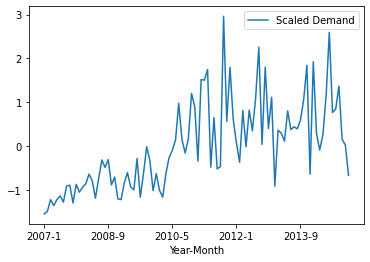

In [ ]:
newdf.plot(x='Year-Month',y='Scaled Demand')

###Treating Outliers

LB = -1.23, UB = 1.81


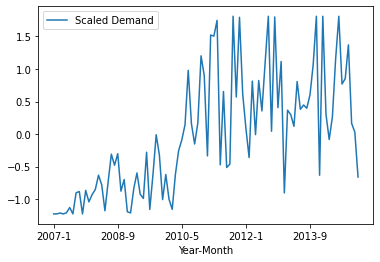

In [ ]:
newdf=remove_outliers(newdf,'Scaled Demand')
newdf.plot(x='Year-Month',y='Scaled Demand')

##XGBoost

In [ ]:
test,train,xtrain,xtest,ytrain,ytest=split_data(newdf,0.9)

train_num=86, test_num=10


In [ ]:
reg = xgb.XGBRegressor(booster='gbtree',
                       n_estimators=4000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=4,
                       learning_rate=0.0001)

reg.fit(xtrain, ytrain,
        eval_set=[(xtrain, ytrain), (xtest, ytest)],
        verbose=1000)

[0]	validation_0-rmse:1.09509	validation_1-rmse:0.719238
[1000]	validation_0-rmse:1.02084	validation_1-rmse:0.709466
[2000]	validation_0-rmse:0.955116	validation_1-rmse:0.70222
[3000]	validation_0-rmse:0.897089	validation_1-rmse:0.699241
[3999]	validation_0-rmse:0.84533	validation_1-rmse:0.698221


XGBRegressor(early_stopping_rounds=50, learning_rate=0.0001, max_depth=4,
             n_estimators=4000, objective='reg:squarederror')

### Graph of Truth Data vs Prediction Data

<ipython-input-25-bbf4e43a5737>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(xtest)


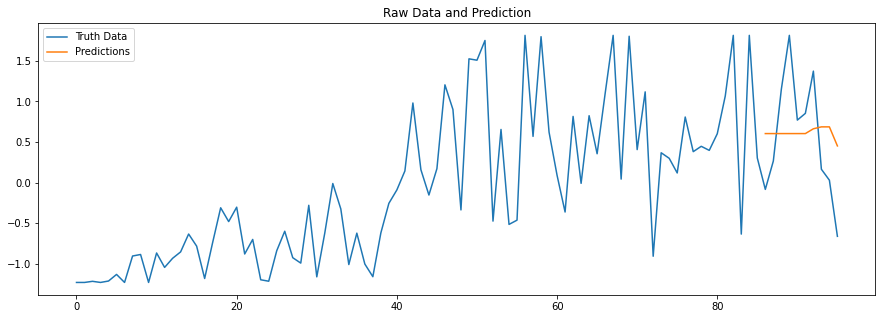

In [ ]:
test['prediction'] = reg.predict(xtest)
tempdf = newdf.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = tempdf[['Scaled Demand']].plot(figsize=(15, 5))
tempdf.plot.line(y='prediction',ax=ax) #, style='.'
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

###Evaluation

In [ ]:
evaluation(xtrain,xtest,ytrain,ytest)

MSE   train: 0.71, test: 0.49
RMSE  train: 0.85, test: 0.70
MAE   train: 0.74, test: 0.62


## Clustering

In [ ]:
clusterdf=df[['Weight (Kilograms)','Freight Cost (USD)','Scheduled Delivery Date','Line Item Quantity']]

In [ ]:
clusterdf=clusterdf[pd.to_numeric(df['Freight Cost (USD)'], errors='coerce').notnull()]
clusterdf=clusterdf[pd.to_numeric(df['Weight (Kilograms)'], errors='coerce').notnull()]
clusterdf.shape

<ipython-input-28-0ee348e5e7a0>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clusterdf=clusterdf[pd.to_numeric(df['Weight (Kilograms)'], errors='coerce').notnull()]


(6175, 4)

In [ ]:
clusterdf=clusterdf.astype({'Weight (Kilograms)':float,'Freight Cost (USD)':float})

In [ ]:
clusterdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6175 entries, 0 to 10316
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Weight (Kilograms)       6175 non-null   float64
 1   Freight Cost (USD)       6175 non-null   float64
 2   Scheduled Delivery Date  6175 non-null   object 
 3   Line Item Quantity       6175 non-null   int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 241.2+ KB


####Removing Outliers and Scaling

In [ ]:
clusterdf=remove_outliers(clusterdf,'Weight (Kilograms)')
clusterdf=remove_outliers(clusterdf,'Freight Cost (USD)')
clusterdf.shape

LB = 19.00, UB = 12953.70
LB = 641.05, UB = 36682.68


(6175, 4)

In [ ]:
scaler = StandardScaler()
scaled = scaler.fit_transform(clusterdf[['Weight (Kilograms)', 'Freight Cost (USD)']])
scaled = pd.DataFrame(scaled)
scaled.columns = ['Weight (Kilograms)', 'Freight Cost (USD)']
scaled

,Weight (Kilograms),Freight Cost (USD)
0,-0.728129,-0.895681
1,-0.631449,-0.526550
2,-0.684780,-0.809501
3,-0.204517,0.606699
4,1.431059,2.646707
...,...,...
6170,2.960743,1.817382
6171,-0.304619,-0.809489
6172,-0.091011,-0.599148
6173,2.960743,1.610436


### Implementation of K-means Algorithm

In [ ]:
for i in range (2,7):
    kmeans = KMeans (n_clusters=i, max_iter=50).fit(scaled)
    cluster_labels=kmeans.labels_
    silhouette_avg=silhouette_score(scaled, cluster_labels)
    print('For n_cluster{} the silhouette score is {}'.format(i, silhouette_avg))

For n_cluster2 the silhouette score is 0.6091568505512039
For n_cluster3 the silhouette score is 0.591495361402615
For n_cluster4 the silhouette score is 0.6023183198529786
For n_cluster5 the silhouette score is 0.5300998152282779
For n_cluster6 the silhouette score is 0.5591100427508233


In [ ]:
score=[]
for i in range (2,7):
    kmeans=KMeans (n_clusters=i, max_iter=50, verbose=False).fit(scaled)
    score.append(kmeans.inertia_)

In [ ]:
len(score)

5

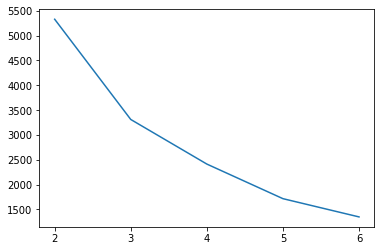

In [ ]:
plt.plot(range(2,7,1), score)
plt.xticks(ticks=range(2,7))
plt.show()

As shown in the Elbow graph, the ideal k-value is 3.

In [ ]:
kmeans = KMeans(n_clusters=3, max_iter=50). fit(scaled)
clusters = kmeans.labels_+1

In [ ]:
clusterdf['Cluster']=clusters

In [ ]:
clusterdf.head()

,Weight (Kilograms),Freight Cost (USD),Scheduled Delivery Date,Line Item Quantity,Cluster
0,19.0,780.340,2-Jun-06,19,2
1,358.0,4521.500,14-Nov-06,1000,2
2,171.0,1653.780,27-Aug-06,500,2
3,1855.0,16007.060,1-Sep-06,31920,1
4,7590.0,36682.678,11-Aug-06,38000,1


In [ ]:
clusterdf['Cluster'].unique()

array([2, 1, 3], dtype=int32)

###Observing Clustering Results

In [ ]:
clusterdf.groupby('Cluster').size()

Cluster
1    1221
2    4228
3     726
dtype: int64

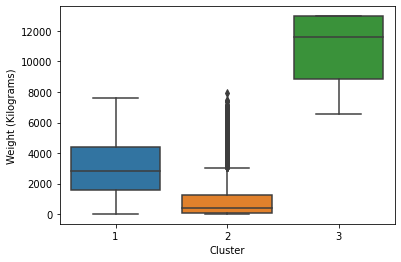

In [ ]:
sns.boxplot(x='Cluster', y='Weight (Kilograms)', data=clusterdf)

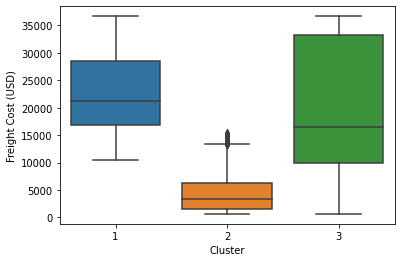

In [ ]:
sns.boxplot(x='Cluster', y='Freight Cost (USD)', data=clusterdf)

Cluster 1: Low weight, low freight cost<br>
Cluster 2: Moderate weight, high freight cost<br>
Cluster 3: High weight, high freight cost

##Forecasting based on Clusters

###Preparing df for forecasting by clusters

In [ ]:
clusterdf['Date']=pd.to_datetime(clusterdf['Scheduled Delivery Date'],format='%d-%b-%y')
clusterdf['Month']=clusterdf['Date'].dt.month
clusterdf['Year']=clusterdf['Date'].dt.year
clusterdf.head()

,Weight (Kilograms),Freight Cost (USD),Scheduled Delivery Date,Line Item Quantity,Cluster,Date,Month,Year
0,19.0,780.340,2-Jun-06,19,2,2006-06-02,6,2006
1,358.0,4521.500,14-Nov-06,1000,2,2006-11-14,11,2006
2,171.0,1653.780,27-Aug-06,500,2,2006-08-27,8,2006
3,1855.0,16007.060,1-Sep-06,31920,1,2006-09-01,9,2006
4,7590.0,36682.678,11-Aug-06,38000,1,2006-08-11,8,2006


In [ ]:
clusterdf_month=clusterdf[['Year','Month','Cluster','Line Item Quantity']]
clusterdf_agg=clusterdf_month.groupby(['Year','Month','Cluster']).agg('sum')
clusterdf_agg=clusterdf_agg.reset_index()
clusterdf_agg=clusterdf_agg.rename(columns={clusterdf_agg.columns[-1]:'Demand'})

In [ ]:
clusterdf_agg

,Year,Month,Cluster,Demand
0,2006,5,2,75
1,2006,6,2,166
2,2006,7,2,6
3,2006,8,1,38000
4,2006,8,2,1019
...,...,...,...,...
313,2015,7,1,16750
314,2015,7,2,250343
315,2015,7,3,24300
316,2015,8,1,12000


In [ ]:
scaler = StandardScaler()
scaleddf = scaler.fit_transform(clusterdf_agg[['Demand']])
scaleddf = pd.DataFrame(scaleddf)
scaleddf.columns=['Demand']

In [ ]:
clusterdf_agg['Scaled Demand']=scaleddf['Demand']

In [ ]:
cluster1df=clusterdf_agg[clusterdf_agg['Cluster']==1]
cluster1df

,Year,Month,Cluster,Demand,Scaled Demand
3,2006,8,1,38000,-0.862125
5,2006,9,1,67603,-0.794794
9,2006,11,1,38780,-0.860351
14,2007,1,1,5150,-0.936841
16,2007,2,1,10400,-0.924900
...,...,...,...,...,...
304,2015,4,1,102157,-0.716202
307,2015,5,1,248043,-0.384390
310,2015,6,1,494703,0.176629
313,2015,7,1,16750,-0.910457


In [ ]:
cluster2df=clusterdf_agg[clusterdf_agg['Cluster']==2]
cluster2df

,Year,Month,Cluster,Demand,Scaled Demand
0,2006,5,2,75,-0.948384
1,2006,6,2,166,-0.948177
2,2006,7,2,6,-0.948541
4,2006,8,2,1019,-0.946237
6,2006,9,2,7544,-0.931396
...,...,...,...,...,...
305,2015,4,2,195104,-0.504798
308,2015,5,2,360240,-0.129202
311,2015,6,2,451268,0.077838
314,2015,7,2,250343,-0.379159


In [ ]:
cluster3df=clusterdf_agg[clusterdf_agg['Cluster']==3]
cluster3df

,Year,Month,Cluster,Demand,Scaled Demand
8,2006,10,3,600,-0.947190
11,2006,11,3,3580,-0.940412
13,2006,12,3,60784,-0.810304
20,2007,3,3,95500,-0.731343
25,2007,5,3,85158,-0.754866
...,...,...,...,...,...
303,2015,3,3,1670664,2.851308
306,2015,4,3,1021105,1.373911
309,2015,5,3,1998905,3.597880
312,2015,6,3,1625551,2.748700


In [ ]:
def setConsecutiveMonth(df):
  multi_index = pd.MultiIndex.from_product([df['Year'].unique(), range(1,13)], names=['Year', 'Month'])
  temp = df.set_index(['Year','Month']).reindex(multi_index).reset_index()
  temp=temp.drop(temp.index[0:6])
  temp.replace(to_replace=[np.nan],value=[0],inplace=True)
  temp['Demand']=temp['Demand'].astype(int)
  newdf=temp.reset_index(drop=True)
  newdf['Year-Month']=newdf['Year'].astype(str)+"-"+newdf['Month'].astype(str)
  return newdf

In [ ]:
def dropExtraMonth(df):
  df=df[df['Year']!=2006]
  df=df[df['Year']!=2015]
  return df

In [ ]:
cluster1df=setConsecutiveMonth(cluster1df)
cluster1df

,Year,Month,Cluster,Demand,Scaled Demand,Year-Month
0,2006,7,0.0,0,0.000000,2006-7
1,2006,8,1.0,38000,-0.862125,2006-8
2,2006,9,1.0,67603,-0.794794,2006-9
3,2006,10,0.0,0,0.000000,2006-10
4,2006,11,1.0,38780,-0.860351,2006-11
...,...,...,...,...,...,...
109,2015,8,1.0,12000,-0.921261,2015-8
110,2015,9,0.0,0,0.000000,2015-9
111,2015,10,0.0,0,0.000000,2015-10
112,2015,11,0.0,0,0.000000,2015-11


In [ ]:
cluster1df=dropExtraMonth(cluster1df)
cluster1df

,Year,Month,Cluster,Demand,Scaled Demand,Year-Month
6,2007,1,1.0,5150,-0.936841,2007-1
7,2007,2,1.0,10400,-0.924900,2007-2
8,2007,3,1.0,124500,-0.665384,2007-3
9,2007,4,1.0,81933,-0.762201,2007-4
10,2007,5,1.0,121549,-0.672096,2007-5
...,...,...,...,...,...,...
97,2014,8,1.0,239507,-0.403805,2014-8
98,2014,9,1.0,516744,0.226760,2014-9
99,2014,10,1.0,371110,-0.104479,2014-10
100,2014,11,1.0,491980,0.170436,2014-11


In [ ]:
cluster1df[cluster1df['Demand']==0]

,Year,Month,Cluster,Demand,Scaled Demand,Year-Month


In [ ]:
cluster2df=setConsecutiveMonth(cluster2df)
cluster2df

,Year,Month,Cluster,Demand,Scaled Demand,Year-Month
0,2006,7,2.0,6,-0.948541,2006-7
1,2006,8,2.0,1019,-0.946237,2006-8
2,2006,9,2.0,7544,-0.931396,2006-9
3,2006,10,2.0,3528,-0.940530,2006-10
4,2006,11,2.0,20727,-0.901412,2006-11
...,...,...,...,...,...,...
109,2015,8,2.0,10211,-0.925330,2015-8
110,2015,9,0.0,0,0.000000,2015-9
111,2015,10,0.0,0,0.000000,2015-10
112,2015,11,0.0,0,0.000000,2015-11


In [ ]:
cluster2df=dropExtraMonth(cluster2df)
cluster2df

,Year,Month,Cluster,Demand,Scaled Demand,Year-Month
6,2007,1,2.0,39430,-0.858872,2007-1
7,2007,2,2.0,14025,-0.916655,2007-2
8,2007,3,2.0,53224,-0.827499,2007-3
9,2007,4,2.0,108536,-0.701693,2007-4
10,2007,5,2.0,120741,-0.673934,2007-5
...,...,...,...,...,...,...
97,2014,8,2.0,401824,-0.034621,2014-8
98,2014,9,2.0,394531,-0.051209,2014-9
99,2014,10,2.0,450398,0.075859,2014-10
100,2014,11,2.0,357420,-0.135616,2014-11


In [ ]:
cluster2df[cluster2df['Demand']==0]

,Year,Month,Cluster,Demand,Scaled Demand,Year-Month


In [ ]:
cluster3df=setConsecutiveMonth(cluster3df)
cluster3df

,Year,Month,Cluster,Demand,Scaled Demand,Year-Month
0,2006,7,0.0,0,0.000000,2006-7
1,2006,8,0.0,0,0.000000,2006-8
2,2006,9,0.0,0,0.000000,2006-9
3,2006,10,3.0,600,-0.947190,2006-10
4,2006,11,3.0,3580,-0.940412,2006-11
...,...,...,...,...,...,...
109,2015,8,0.0,0,0.000000,2015-8
110,2015,9,0.0,0,0.000000,2015-9
111,2015,10,0.0,0,0.000000,2015-10
112,2015,11,0.0,0,0.000000,2015-11


In [ ]:
cluster3df=dropExtraMonth(cluster3df)
cluster3df

,Year,Month,Cluster,Demand,Scaled Demand,Year-Month
6,2007,1,0.0,0,0.000000,2007-1
7,2007,2,0.0,0,0.000000,2007-2
8,2007,3,3.0,95500,-0.731343,2007-3
9,2007,4,0.0,0,0.000000,2007-4
10,2007,5,3.0,85158,-0.754866,2007-5
...,...,...,...,...,...,...
97,2014,8,3.0,642658,0.513147,2014-8
98,2014,9,3.0,1167881,1.707747,2014-9
99,2014,10,3.0,752932,0.763961,2014-10
100,2014,11,3.0,564267,0.334850,2014-11


In [ ]:
cluster3df[cluster3df['Demand']==0]

,Year,Month,Cluster,Demand,Scaled Demand,Year-Month
6,2007,1,0.0,0,0.0,2007-1
7,2007,2,0.0,0,0.0,2007-2
9,2007,4,0.0,0,0.0,2007-4
12,2007,7,0.0,0,0.0,2007-7
15,2007,10,0.0,0,0.0,2007-10
30,2009,1,0.0,0,0.0,2009-1
43,2010,2,0.0,0,0.0,2010-2


###Cluster 1

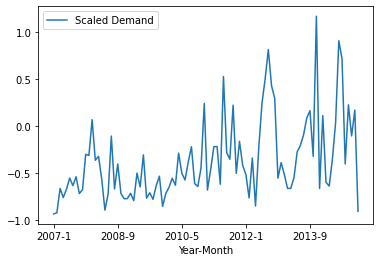

In [ ]:
cluster1df.plot(x='Year-Month',y='Scaled Demand')

LB = -0.85, UB = 0.51


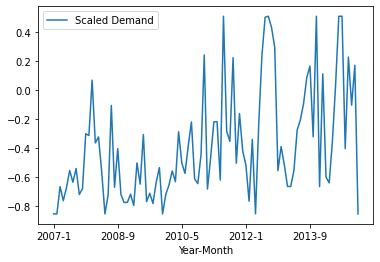

In [ ]:
cluster1df=remove_outliers(cluster1df,'Scaled Demand')
cluster1df.plot(x='Year-Month',y='Scaled Demand')

####XGBoost

In [ ]:
test1,train1,xtrain1,xtest1,ytrain1,ytest1=split_data(cluster1df,0.9)

train_num=80, test_num=16


#####Without Hyper-parameter Tuning

In [ ]:
reg = xgb.XGBRegressor(booster='gbtree',
                       objective='reg:squarederror')
reg.fit(xtrain1, ytrain1,
        eval_set=[(xtrain1, ytrain1), (xtest1, ytest1)],
        verbose=1000)

[0]	validation_0-rmse:0.906456	validation_1-rmse:0.68932
[99]	validation_0-rmse:0.155702	validation_1-rmse:0.446156


XGBRegressor(objective='reg:squarederror')

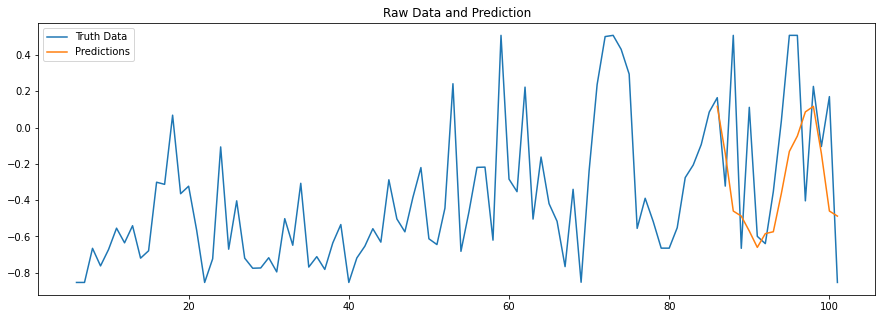

In [ ]:
temp1=test1.copy()
temp1['prediction'] = reg.predict(xtest1)
temp1 = cluster1df.merge(temp1[['prediction']], how='left', left_index=True, right_index=True)
ax = temp1[['Scaled Demand']].plot(figsize=(15, 5))
temp1.plot.line(y='prediction',ax=ax) #, style='.'
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [ ]:
evaluation(xtrain1,xtest1,ytrain1,ytest1)

MSE   train: 0.02, test: 0.20
RMSE  train: 0.16, test: 0.45
MAE   train: 0.12, test: 0.35


#####Hyper-parameter Tuning

In [ ]:
n_estimator=[3000,5000]
early_stopping_rounds=[50,100]
max_depth=[2,4,6]
learning_rate=[0.005,0.01,0.05]

hyper_parameter_score_list=[]
for n in n_estimator:
  for r in early_stopping_rounds:
    for d in max_depth:
      for l in learning_rate:
        reg=xgb.XGBRegressor(booster='gbtree',
                             n_estimators=n,
                             early_stopping_rounds=r,
                             max_depth=d,
                             learning_rate=l,
                             objective='reg:squarederror')
        # k = 10
        scores=cross_validate(reg,xtest1,ytest1,cv=2,
                              scoring='neg_root_mean_squared_error')
        mean_scores=np.mean(scores['test_score'])
        hyper_parameter_score_list.append([n,r,d,l,mean_scores])

In [ ]:
mytable=PrettyTable(['n_estimators','early stopping rounds','max depth','learning rate','RMSE'])
score_list=[]
for row in hyper_parameter_score_list:
  mytable.add_row([row[0],row[1],row[2],row[3],round(row[4],3)])
  score_list.append(row[4])
print(mytable)

for row in hyper_parameter_score_list:
  if row[4]==max(score_list):
    print(row[0],row[1],row[2],row[3],row[4])
    n,r,d,l=row[0],row[1],row[2],row[3]

+--------------+-----------------------+-----------+---------------+--------+
| n_estimators | early stopping rounds | max depth | learning rate |  RMSE  |
+--------------+-----------------------+-----------+---------------+--------+
|     3000     |           50          |     2     |     0.005     | -0.462 |
|     3000     |           50          |     2     |      0.01     | -0.458 |
|     3000     |           50          |     2     |      0.05     | -0.459 |
|     3000     |           50          |     4     |     0.005     | -0.457 |
|     3000     |           50          |     4     |      0.01     | -0.457 |
|     3000     |           50          |     4     |      0.05     | -0.457 |
|     3000     |           50          |     6     |     0.005     | -0.454 |
|     3000     |           50          |     6     |      0.01     | -0.454 |
|     3000     |           50          |     6     |      0.05     | -0.454 |
|     3000     |          100          |     2     |     0.005  

In [ ]:
reg = xgb.XGBRegressor(booster='gbtree',
                       n_estimators=n,
                       early_stopping_rounds=r,
                       objective='reg:squarederror',
                       max_depth=d,
                       learning_rate=l)
reg.fit(xtrain1, ytrain1,
        eval_set=[(xtrain1, ytrain1), (xtest1, ytest1)],
        verbose=1000)

[0]	validation_0-rmse:0.991772	validation_1-rmse:0.744808
[1000]	validation_0-rmse:0.097238	validation_1-rmse:0.439644
[2000]	validation_0-rmse:0.04101	validation_1-rmse:0.46729
[2999]	validation_0-rmse:0.017154	validation_1-rmse:0.475703


XGBRegressor(early_stopping_rounds=100, learning_rate=0.005, max_depth=6,
             n_estimators=3000, objective='reg:squarederror')

##### Graph of Truth Data vs Prediction Data

<ipython-input-72-afc18a9ca909>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1['prediction'] = reg.predict(xtest1)


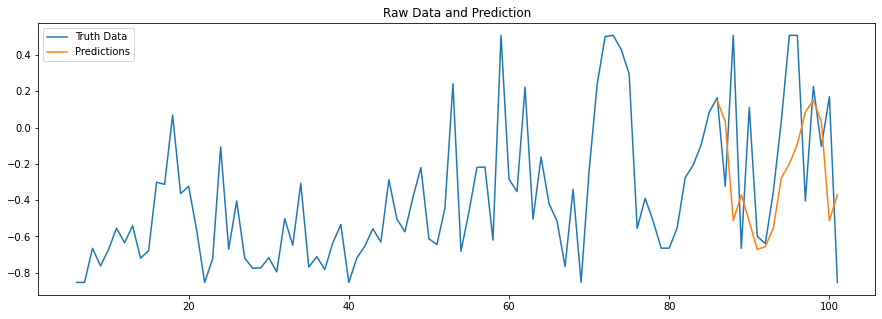

In [ ]:
test1['prediction'] = reg.predict(xtest1)
cluster1df = cluster1df.merge(test1[['prediction']], how='left', left_index=True, right_index=True)
ax = cluster1df[['Scaled Demand']].plot(figsize=(15, 5))
cluster1df.plot.line(y='prediction',ax=ax) #, style='.'
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

#####Evaluation

In [ ]:
evaluation(xtrain1,xtest1,ytrain1,ytest1)

MSE   train: 0.00, test: 0.23
RMSE  train: 0.02, test: 0.48
MAE   train: 0.01, test: 0.38


###Cluster 2

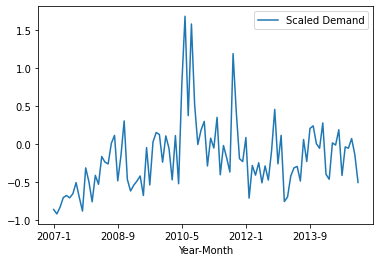

In [ ]:
cluster2df.plot(x='Year-Month',y='Scaled Demand')

LB = -0.75, UB = 0.48


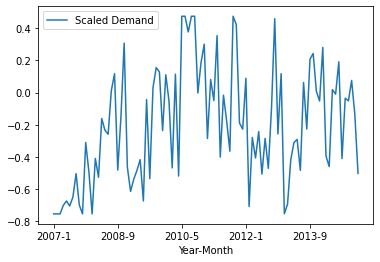

In [ ]:
cluster2df=remove_outliers(cluster2df,'Scaled Demand')
cluster2df.plot(x='Year-Month',y='Scaled Demand')

####XGBoost

In [ ]:
test2,train2,xtrain2,xtest2,ytrain2,ytest2=split_data(cluster2df,0.9)

train_num=80, test_num=16


#####Without Hyper-parameter Tuning

In [ ]:
reg = xgb.XGBRegressor(booster='gbtree',
                       objective='reg:squarederror')
reg.fit(xtrain2, ytrain2,
        eval_set=[(xtrain2, ytrain2), (xtest2, ytest2)],
        verbose=1000)

[0]	validation_0-rmse:0.747309	validation_1-rmse:0.562075
[99]	validation_0-rmse:0.176135	validation_1-rmse:0.370947


XGBRegressor(objective='reg:squarederror')

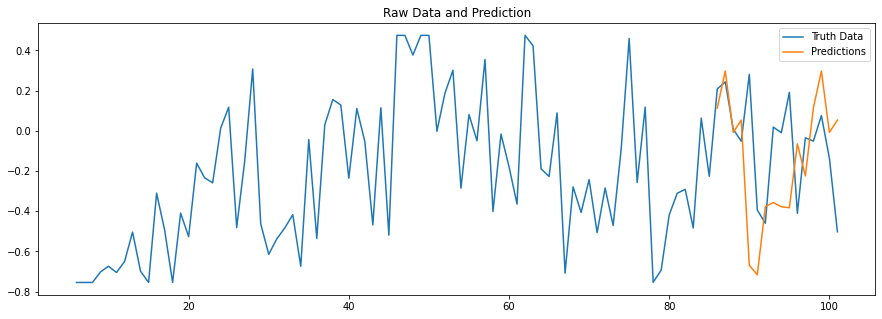

In [ ]:
temp2=test2.copy()
temp2['prediction'] = reg.predict(xtest2)
temp2 = cluster2df.merge(temp2[['prediction']], how='left', left_index=True, right_index=True)
ax = temp2[['Scaled Demand']].plot(figsize=(15, 5))
temp2.plot.line(y='prediction',ax=ax) #, style='.'
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [ ]:
evaluation(xtrain2,xtest2,ytrain2,ytest2)

MSE   train: 0.03, test: 0.14
RMSE  train: 0.18, test: 0.37
MAE   train: 0.13, test: 0.28


#####Hyper-parameter Tuning

In [ ]:
n_estimator=[3000,5000]
early_stopping_rounds=[50,100]
max_depth=[2,4,6]
learning_rate=[0.005,0.01,0.05]

hyper_parameter_score_list=[]
for n in n_estimator:
  for r in early_stopping_rounds:
    for d in max_depth:
      for l in learning_rate:
        reg=xgb.XGBRegressor(booster='gbtree',
                             n_estimators=n,
                             early_stopping_rounds=r,
                             max_depth=d,
                             learning_rate=l,
                             objective='reg:squarederror')
        # k = 10
        scores=cross_validate(reg,xtest2,ytest2,cv=2,
                              scoring='neg_root_mean_squared_error')
        mean_scores=np.mean(scores['test_score'])
        hyper_parameter_score_list.append([n,r,d,l,mean_scores])

In [ ]:
mytable=PrettyTable(['n_estimators','early stopping rounds','max depth','learning rate','RMSE'])
score_list=[]
for row in hyper_parameter_score_list:
  mytable.add_row([row[0],row[1],row[2],row[3],round(row[4],3)])
  score_list.append(row[4])
print(mytable)
for row in hyper_parameter_score_list:
  if row[4]==max(score_list):
    print(row[0],row[1],row[2],row[3],row[4])
    n,r,d,l=row[0],row[1],row[2],row[3]

+--------------+-----------------------+-----------+---------------+--------+
| n_estimators | early stopping rounds | max depth | learning rate |  RMSE  |
+--------------+-----------------------+-----------+---------------+--------+
|     3000     |           50          |     2     |     0.005     | -0.259 |
|     3000     |           50          |     2     |      0.01     | -0.26  |
|     3000     |           50          |     2     |      0.05     | -0.259 |
|     3000     |           50          |     4     |     0.005     | -0.263 |
|     3000     |           50          |     4     |      0.01     | -0.263 |
|     3000     |           50          |     4     |      0.05     | -0.263 |
|     3000     |           50          |     6     |     0.005     | -0.263 |
|     3000     |           50          |     6     |      0.01     | -0.263 |
|     3000     |           50          |     6     |      0.05     | -0.263 |
|     3000     |          100          |     2     |     0.005  

In [ ]:
reg = xgb.XGBRegressor(booster='gbtree',
                       n_estimators=n,
                       early_stopping_rounds=r,
                       objective='reg:squarederror',
                       max_depth=d,
                       learning_rate=l)
reg.fit(xtrain2, ytrain2,
        eval_set=[(xtrain2, ytrain2), (xtest2, ytest2)],
        verbose=1000)

[0]	validation_0-rmse:0.811092	validation_1-rmse:0.612711
[1000]	validation_0-rmse:0.228848	validation_1-rmse:0.318526
[2000]	validation_0-rmse:0.215497	validation_1-rmse:0.324917
[2999]	validation_0-rmse:0.206613	validation_1-rmse:0.338469


XGBRegressor(early_stopping_rounds=100, learning_rate=0.005, max_depth=2,
             n_estimators=3000, objective='reg:squarederror')

##### Graph of Truth Data vs Prediction Data

<ipython-input-83-4f1e959bbba1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test2['prediction'] = reg.predict(xtest2)


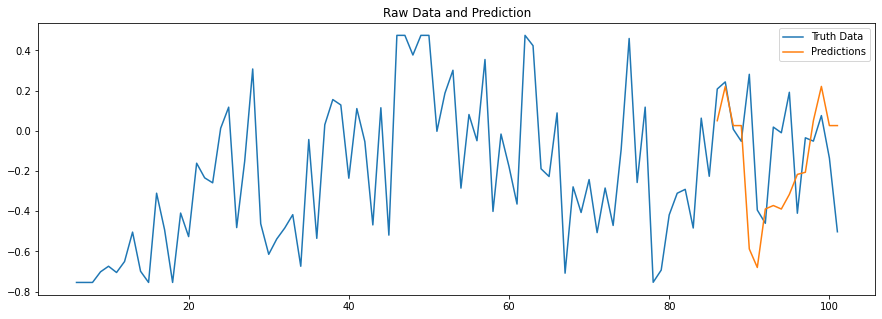

In [ ]:
test2['prediction'] = reg.predict(xtest2)
cluster2df = cluster2df.merge(test2[['prediction']], how='left', left_index=True, right_index=True)
ax = cluster2df[['Scaled Demand']].plot(figsize=(15, 5))
cluster2df.plot.line(y='prediction',ax=ax) #, style='.'
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

#####Evaluation

In [ ]:
evaluation(xtrain2,xtest2,ytrain2,ytest2)

MSE   train: 0.04, test: 0.11
RMSE  train: 0.21, test: 0.34
MAE   train: 0.16, test: 0.26


###Cluster 3

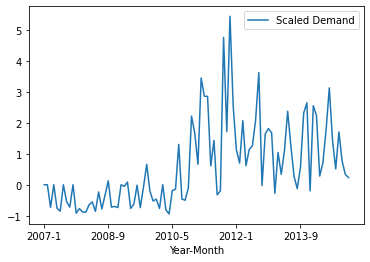

In [ ]:
cluster3df.plot(x='Year-Month',y='Scaled Demand')

LB = -0.86, UB = 2.93


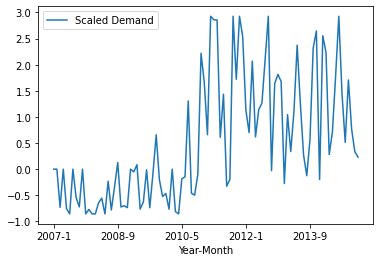

In [ ]:
cluster3df=remove_outliers(cluster3df,'Scaled Demand')
cluster3df.plot(x='Year-Month',y='Scaled Demand')

####XGBoost

In [ ]:
test3,train3,xtrain3,xtest3,ytrain3,ytest3=split_data(cluster3df,0.9)

train_num=80, test_num=16


#####Without Hyper-parameter Tuning

In [ ]:
reg = xgb.XGBRegressor(booster='gbtree',
                       objective='reg:squarederror')
reg.fit(xtrain3, ytrain3,
        eval_set=[(xtrain3, ytrain3), (xtest3, ytest3)],
        verbose=1000)

[0]	validation_0-rmse:1.09608	validation_1-rmse:1.26187
[99]	validation_0-rmse:0.482681	validation_1-rmse:1.33044


XGBRegressor(objective='reg:squarederror')

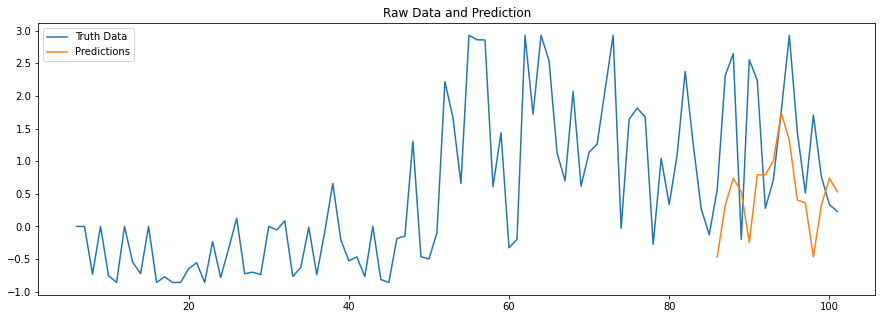

In [ ]:
temp3=test3.copy()
temp3['prediction'] = reg.predict(xtest3)
temp3 = cluster3df.merge(temp3[['prediction']], how='left', left_index=True, right_index=True)
ax = temp3[['Scaled Demand']].plot(figsize=(15, 5))
temp3.plot.line(y='prediction',ax=ax) #, style='.'
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [ ]:
evaluation(xtrain3,xtest3,ytrain3,ytest3)

MSE   train: 0.23, test: 1.77
RMSE  train: 0.48, test: 1.33
MAE   train: 0.36, test: 1.05


#####Hyper-parameter Tuning

In [ ]:
n_estimator=[3000,5000]
early_stopping_rounds=[50,100]
max_depth=[2,4,6]
learning_rate=[0.005,0.01,0.05]

hyper_parameter_score_list=[]
for n in n_estimator:
  for r in early_stopping_rounds:
    for d in max_depth:
      for l in learning_rate:
        reg=xgb.XGBRegressor(booster='gbtree',
                             n_estimators=n,
                             early_stopping_rounds=r,
                             max_depth=d,
                             learning_rate=l,
                             objective='reg:squarederror')
        # k = 10
        scores=cross_validate(reg,xtest3,ytest3,cv=2,
                              scoring='neg_root_mean_squared_error')
        mean_scores=np.mean(scores['test_score'])
        hyper_parameter_score_list.append([n,r,d,l,mean_scores])

In [ ]:
mytable=PrettyTable(['n_estimators','early stopping rounds','max depth','learning rate','RMSE'])
score_list=[]
for row in hyper_parameter_score_list:
  mytable.add_row([row[0],row[1],row[2],row[3],round(row[4],3)])
  score_list.append(row[4])
print(mytable)
for row in hyper_parameter_score_list:
  if row[4]==max(score_list):
    print(row[0],row[1],row[2],row[3],row[4])
    n,r,d,l=row[0],row[1],row[2],row[3]

+--------------+-----------------------+-----------+---------------+--------+
| n_estimators | early stopping rounds | max depth | learning rate |  RMSE  |
+--------------+-----------------------+-----------+---------------+--------+
|     3000     |           50          |     2     |     0.005     | -1.35  |
|     3000     |           50          |     2     |      0.01     | -1.354 |
|     3000     |           50          |     2     |      0.05     | -1.354 |
|     3000     |           50          |     4     |     0.005     | -1.349 |
|     3000     |           50          |     4     |      0.01     | -1.349 |
|     3000     |           50          |     4     |      0.05     | -1.349 |
|     3000     |           50          |     6     |     0.005     | -1.346 |
|     3000     |           50          |     6     |      0.01     | -1.345 |
|     3000     |           50          |     6     |      0.05     | -1.346 |
|     3000     |          100          |     2     |     0.005  

In [ ]:
reg = xgb.XGBRegressor(booster='gbtree',
                       n_estimators=n,
                       early_stopping_rounds=r,
                       objective='reg:squarederror',
                       max_depth=d,
                       learning_rate=l)
reg.fit(xtrain3, ytrain3,
        eval_set=[(xtrain3, ytrain3), (xtest3, ytest3)],
        verbose=1000)

[0]	validation_0-rmse:1.16267	validation_1-rmse:1.26859
[1000]	validation_0-rmse:0.163255	validation_1-rmse:1.35811
[2000]	validation_0-rmse:0.062145	validation_1-rmse:1.42476
[3000]	validation_0-rmse:0.021061	validation_1-rmse:1.4414
[4000]	validation_0-rmse:0.011793	validation_1-rmse:1.44348
[4999]	validation_0-rmse:0.011792	validation_1-rmse:1.44348


XGBRegressor(early_stopping_rounds=100, learning_rate=0.005, max_depth=6,
             n_estimators=5000, objective='reg:squarederror')

##### Graph of Truth Data vs Prediction Data

<ipython-input-94-a696b97a3fb7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test3['prediction'] = reg.predict(xtest3)


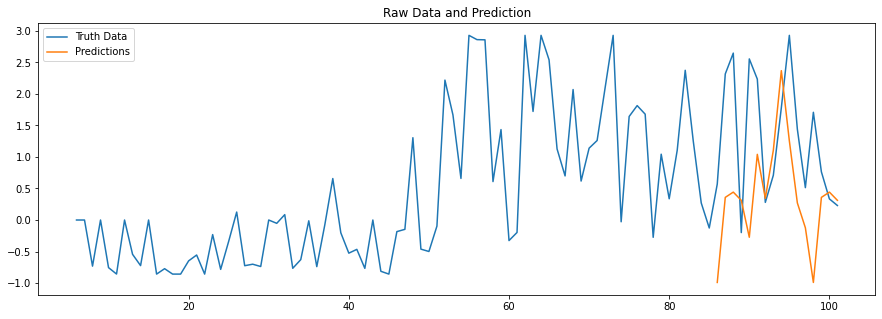

In [ ]:
test3['prediction'] = reg.predict(xtest3)
cluster3df = cluster3df.merge(test3[['prediction']], how='left', left_index=True, right_index=True)
ax = cluster3df[['Scaled Demand']].plot(figsize=(15, 5))
cluster3df.plot.line(y='prediction',ax=ax) #, style='.'
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

#####Evaluation

In [ ]:
evaluation(xtrain3,xtest3,ytrain3,ytest3)

MSE   train: 0.00, test: 2.08
RMSE  train: 0.01, test: 1.44
MAE   train: 0.01, test: 1.13


##Benchmarking

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [ ]:
benchdf=df.copy()

In [ ]:
benchdf['Scheduled Delivery Date']=pd.to_datetime(benchdf['Scheduled Delivery Date'],format='%d-%b-%y')

In [ ]:
newbenchdf=pd.DataFrame(benchdf.groupby('Scheduled Delivery Date').size())
newbenchdf.rename({newbenchdf.columns[-1]:'Frequency'},axis=1,inplace=True)

In [ ]:
newbenchdf.reset_index(inplace=True)
newbenchdf = newbenchdf.set_index(pd.DatetimeIndex(newbenchdf['Scheduled Delivery Date']))
# newbenchdf.drop(columns={'Scheduled Delivery Date'},inplace=True)

In [ ]:
newbenchdf['Year']=newbenchdf['Scheduled Delivery Date'].dt.year
newbenchdf=newbenchdf[newbenchdf['Year']!=2007]
newbenchdf=newbenchdf[newbenchdf['Year']!=2014]
newbenchdf=newbenchdf[newbenchdf['Year']!=2015]
newbenchdf

,Scheduled Delivery Date,Frequency,Year
Scheduled Delivery Date,,,
2006-05-02,2006-05-02,1,2006
2006-05-10,2006-05-10,1,2006
2006-06-02,2006-06-02,1,2006
2006-06-27,2006-06-27,1,2006
2006-07-14,2006-07-14,1,2006
...,...,...,...
2013-12-26,2013-12-26,3,2013
2013-12-27,2013-12-27,3,2013
2013-12-29,2013-12-29,1,2013


####Identification of Trend and Seasonality in Data

In [ ]:
def holt_win_sea(y,y_to_train,y_to_test,seasonal_type,seasonal_period,predict_date):

    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))

    if seasonal_type == 'additive':
        fit1 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add').fit(use_boxcox=True)
        fcast1 = fit1.forecast(predict_date).rename('Additive')
        mse1 = ((fcast1 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, additive seasonal of '+
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))

        fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
        fcast2 = fit2.forecast(predict_date).rename('Additive+damped')
        mse2 = ((fcast2 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, additive seasonal of '+
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse2), 2)))

        fit1.fittedvalues.plot(style='--', color='red')
        fcast1.plot(style='--', marker='o', color='red', legend=True)
        fit2.fittedvalues.plot(style='--', color='green')
        fcast2.plot(style='--', marker='o', color='green', legend=True)

    elif seasonal_type == 'multiplicative':
        fit3 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul').fit(use_boxcox=True)
        fcast3 = fit3.forecast(predict_date).rename('Multiplicative')
        mse3 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, multiplicative seasonal of '+
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse3), 2)))

        fit4 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
        fcast4 = fit4.forecast(predict_date).rename('Multiplicative+damped')
        mse4 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, multiplicative seasonal of '+
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse4), 2)))

        fit3.fittedvalues.plot(style='--', color='red')
        fcast3.plot(style='--', marker='o', color='red', legend=True)
        fit4.fittedvalues.plot(style='--', color='green')
        fcast4.plot(style='--', marker='o', color='green', legend=True)

    else:
        print('Wrong Seasonal Type. Please choose between additive and multiplicative')

    plt.show()

In [ ]:
def holt_win_sea(y,y_to_train,y_to_test,seasonal_type,seasonal_period,predict_date):

    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))

    if seasonal_type == 'additive':
        fit1 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add').fit(use_boxcox=True)
        fcast1 = fit1.forecast(predict_date).rename('Additive')
        mse1 = ((fcast1 - y_to_test) ** 2).mean()

        fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
        fcast2 = fit2.forecast(predict_date).rename('Additive+damped')
        mse2 = ((fcast2 - y_to_test) ** 2).mean()

        fit1.fittedvalues.plot(style='--', color='red')
        fcast1.plot(style='--', marker='o', color='red', legend=True)
        fit2.fittedvalues.plot(style='--', color='green')
        fcast2.plot(style='--', marker='o', color='green', legend=True)

    elif seasonal_type == 'multiplicative':
        fit3 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul').fit(use_boxcox=True)
        fcast3 = fit3.forecast(predict_date).rename('Multiplicative')
        mse3 = ((fcast3 - y_to_test) ** 2).mean()

        fit4 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
        fcast4 = fit4.forecast(predict_date).rename('Multiplicative+damped')
        mse4 = ((fcast3 - y_to_test) ** 2).mean()

        fit3.fittedvalues.plot(style='--', color='red')
        fcast3.plot(style='--', marker='o', color='red', legend=True)
        fit4.fittedvalues.plot(style='--', color='green')
        fcast4.plot(style='--', marker='o', color='green', legend=True)

    else:
        print('Wrong Seasonal Type. Please choose between additive and multiplicative')

    plt.show()

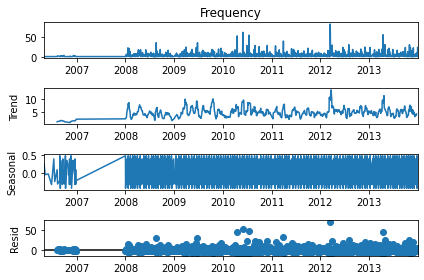

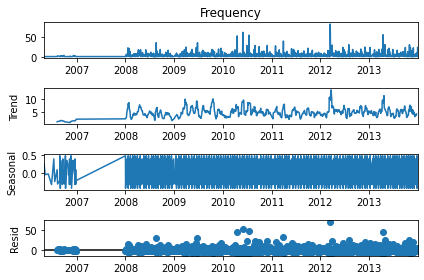

In [ ]:
decompose_result = seasonal_decompose(x=newbenchdf['Frequency'],model='additive',period=12)
decompose_result.plot()

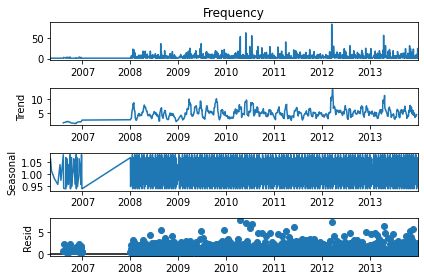

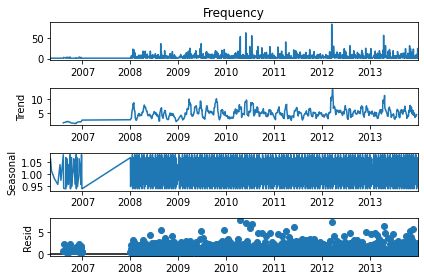

In [ ]:
decompose_result = seasonal_decompose(x=newbenchdf['Frequency'],model='multiplicative',period=12)
decompose_result.plot()

Since there is no significant trend and seasonality shown, Simple Exponential Smoothing model will be used for benchmarking.

####Simple Exponential Smoothing

#####Cluster 1

In [ ]:
from statsmodels.tsa.statespace.exponential_smoothing import ExponentialSmoothing

# Fit simple model and get forecasts
model_simple = SimpleExpSmoothing(cluster1df['Scaled Demand']).fit(optimized=True)
forecasts_simple = model_simple.forecast(len(xtest1))

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


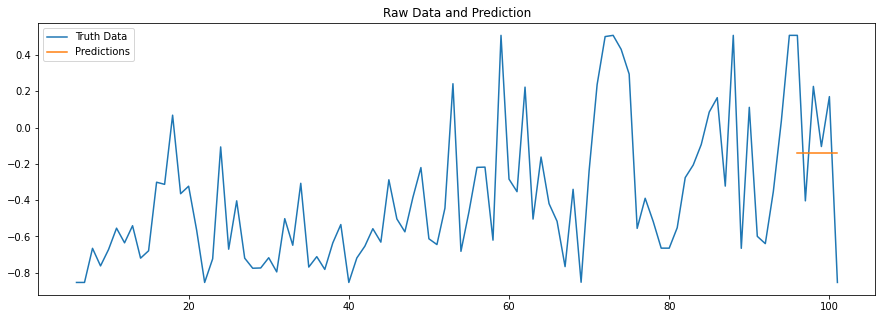

In [ ]:
test=pd.DataFrame()
test['prediction_ses']=forecasts_simple
tempdf1 = cluster1df.merge(test[['prediction_ses']], how='left', left_index=True, right_index=True)
ax = tempdf1[['Scaled Demand']].plot(figsize=(15, 5))
tempdf1.plot.line(y='prediction_ses',ax=ax) #, style='.'
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [ ]:
evaluation(xtrain1,xtest1,ytrain1,forecasts_simple)

MSE   train: 1.76, test: 0.91
RMSE  train: 1.33, test: 0.96
MAE   train: 0.96, test: 0.76


#####Cluster 2

In [ ]:
from statsmodels.tsa.statespace.exponential_smoothing import ExponentialSmoothing

# Fit simple model and get forecasts
model_simple = SimpleExpSmoothing(cluster2df['Scaled Demand']).fit(optimized=True)
forecasts_simple = model_simple.forecast(len(xtest2))

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


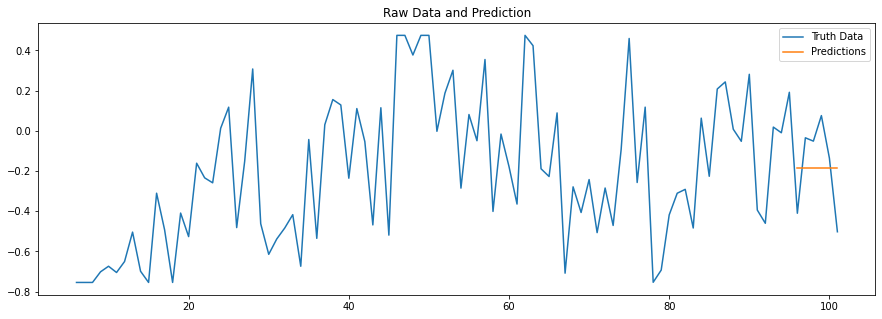

In [ ]:
test=pd.DataFrame()
test['prediction_ses']=forecasts_simple
tempdf2 = cluster2df.merge(test[['prediction_ses']], how='left', left_index=True, right_index=True)
ax = tempdf2[['Scaled Demand']].plot(figsize=(15, 5))
tempdf2.plot.line(y='prediction_ses',ax=ax) #, style='.'
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [ ]:
evaluation(xtrain2,xtest2,ytrain2,forecasts_simple)

MSE   train: 1.59, test: 0.96
RMSE  train: 1.26, test: 0.98
MAE   train: 0.93, test: 0.79


#####Cluster 3

In [ ]:
from statsmodels.tsa.statespace.exponential_smoothing import ExponentialSmoothing

# Fit simple model and get forecasts
model_simple = SimpleExpSmoothing(cluster3df['Scaled Demand']).fit(optimized=True)
forecasts_simple = model_simple.forecast(len(xtest3))

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


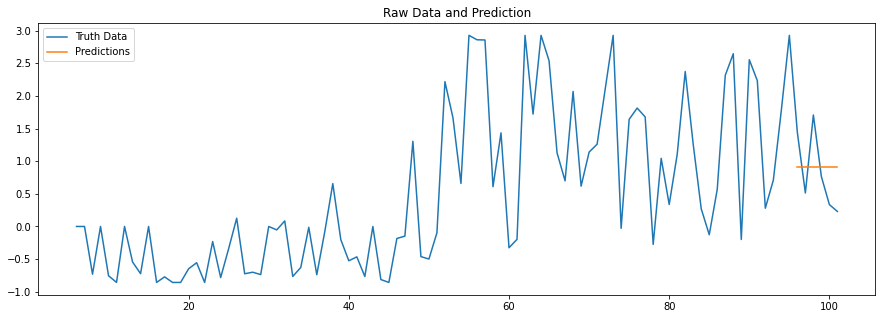

In [ ]:
test=pd.DataFrame()
test['prediction_ses']=forecasts_simple
tempdf3 = cluster3df.merge(test[['prediction_ses']], how='left', left_index=True, right_index=True)
ax = tempdf3[['Scaled Demand']].plot(figsize=(15, 5))
tempdf3.plot.line(y='prediction_ses',ax=ax) #, style='.'
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [ ]:
evaluation(xtrain3,xtest3,ytrain3,forecasts_simple)

MSE   train: 0.00, test: 0.91
RMSE  train: 0.01, test: 0.95
MAE   train: 0.01, test: 0.79


##Export data

In [ ]:
newdf.to_csv('Frequency Data.csv',header=True,index=False)

In [ ]:
cluster1df.to_csv('Cluster 1 Data.csv',header=True,index=False)
cluster2df.to_csv('Cluster 2 Data.csv',header=True,index=False)
cluster3df.to_csv('Cluster 3 Data.csv',header=True,index=False)
tempdf1.to_csv('Cluster 1 Pred Data.csv',header=True,index=False)
tempdf2.to_csv('Cluster 2 Pred Data.csv',header=True,index=False)
tempdf3.to_csv('Cluster 3 Pred Data.csv',header=True,index=False)

In [ ]:
tempdf3

,Year,Month,Cluster,Demand,Scaled Demand,Year-Month,prediction,prediction_ses
6,2007,1,0.0,0,0.000000,2007-1,NaN,NaN
7,2007,2,0.0,0,0.000000,2007-2,NaN,NaN
8,2007,3,3.0,95500,-0.731343,2007-3,NaN,NaN
9,2007,4,0.0,0,0.000000,2007-4,NaN,NaN
10,2007,5,3.0,85158,-0.754866,2007-5,NaN,NaN
...,...,...,...,...,...,...,...,...
97,2014,8,3.0,642658,0.513147,2014-8,-0.122797,0.91587
98,2014,9,3.0,1167881,1.707747,2014-9,-0.989884,0.91587
99,2014,10,3.0,752932,0.763961,2014-10,0.358776,0.91587
100,2014,11,3.0,564267,0.334850,2014-11,0.442336,0.91587
